<a href="https://colab.research.google.com/github/Isaac-Gregory/House-Pricing-SWD/blob/main/housepricing_noiseanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Dataset

In [ ]:
from google.colab import files
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
from scipy.stats import f_oneway, chi2_contingency
from sklearn.preprocessing import StandardScaler

In [ ]:
# Reading in the CSV
data = pd.read_csv('train.csv')
data.drop(['Id'], axis=1, inplace=True)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# Split numerical from categorical features
X_train = data.drop(['SalePrice'], axis=1)
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
print(len(cat_cols), len(num_cols))

43 36


In [ ]:
# Normalize numerical features
scaler = StandardScaler()  # or MinMaxScaler()
num_cols_norm = scaler.fit_transform(data[num_cols])
num_df = pd.DataFrame(num_cols_norm, columns=num_cols)
num_df.head()

# NOTE: Normalizing will help for the model later on, but does not have any
#       impact on the correlation analysis for numerical features (values
#       and evaluation stay the same)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.073375,-0.208034,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.510015,0.575425,-0.288653,...,0.351000,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777
1,-0.872563,0.409895,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.572835,1.171992,-0.288653,...,-0.060731,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439
2,0.073375,-0.084449,0.073480,0.651479,-0.517200,0.984752,0.830215,0.322174,0.092907,-0.288653,...,0.631726,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777
3,0.309859,-0.414011,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.572835,-0.499274,-0.288653,...,0.790804,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655
4,0.073375,0.574676,0.375148,1.374795,-0.517200,0.951632,0.733308,1.360826,0.463568,-0.288653,...,1.698485,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777


##Preprocessing

This code will be used later on for the actual machine learning model. It does not need to be used prior to that.

In [ ]:
def CategorizeStringColumns(og_data):
  # Copying so that the original data object isn't overwritten
  data = cp.deepcopy(og_data)

  # Splitting the numerical and categorical features
  cat_cols = data.select_dtypes(include=['object']).columns.tolist()
  num_cols = data.select_dtypes(include=['number']).columns.tolist()

  # Ensuring there are no overlapping features
  shared_cols = list(set(cat_cols) & set(num_cols))
  if shared_cols != None and shared_cols != []:
    print("Shared:", shared_cols)
    return None

  # Encoding all categorical features
  encoder_list = {}
  for col in cat_cols:
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col])
    encoder_list[col] = encoder

  return data, encoder_list

## Individual Feature Analysis

In [ ]:
nan_cols = {}

# Printing all features with NaN values
for col, i in data.isnull().sum().items():
  if i > 0:
    print(col, i)
    nan_cols[col] = i

# Investigating NaN values in numerical columns
print("---------------------------")
for col in nan_cols:
  if col in num_cols:
    print(col, nan_cols[col])

LotFrontage 259
Alley 1369
MasVnrType 872
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406
---------------------------
LotFrontage 259
MasVnrArea 8
GarageYrBlt 81


**The following is the analysis of the outputted features:**

LotFrontage 259 - May not have street connected to property (should just be set to 0 for NaN values)

Alley 1369 - May not have alley access

MasVnrType 872 - No veneer

MasVnrArea 8 - ???? (should probably set NaN values to 0)

NO BASEMENT:
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38

Electrical 1 - ????

FireplaceQu 690 - No fireplace

NO GARAGE:
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81

PoolQC 1453 - No Pool

Fence 1179 - No fence

MiscFeature 1406 - No miscellaneous (high amount, but potentially highly predictive)

In [ ]:
# Replacing numerical NaNs with zeros
data['LotFrontage'].fillna(0, inplace=True)
data['MasVnrArea'].fillna(0, inplace=True)

# Since NaNs have a meaning in this dataset, we will make them a string part of the feature
# Convert all NaN in cat_cols to strings
for col in cat_cols:
  data[col].fillna('N/A', inplace=True)

### Categorical Class Distribution Analysis

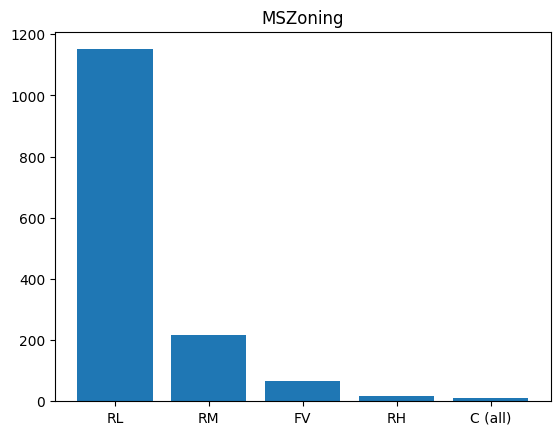

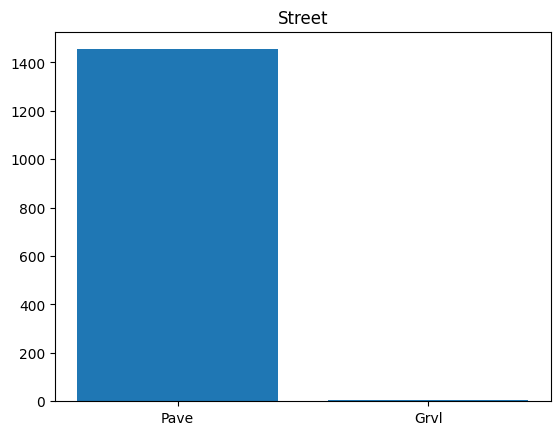

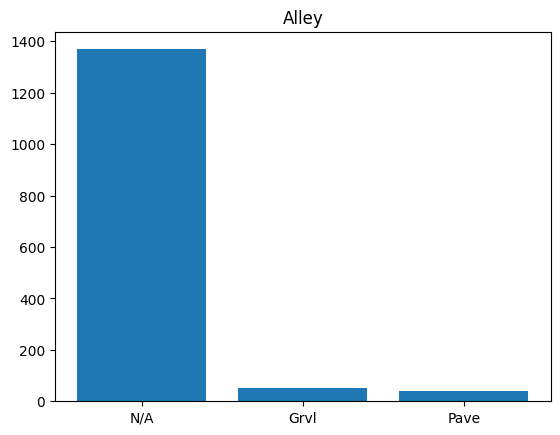

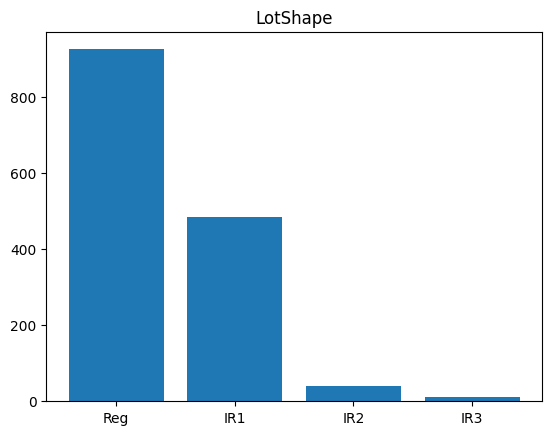

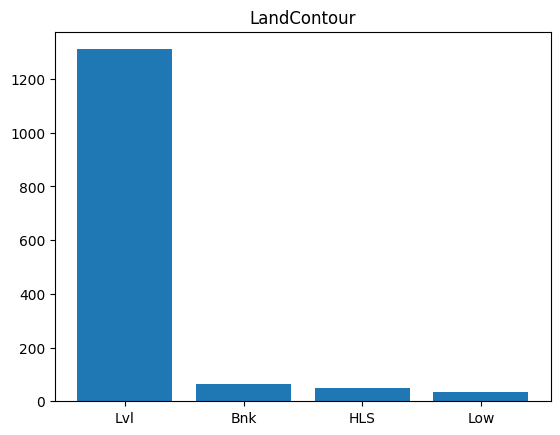

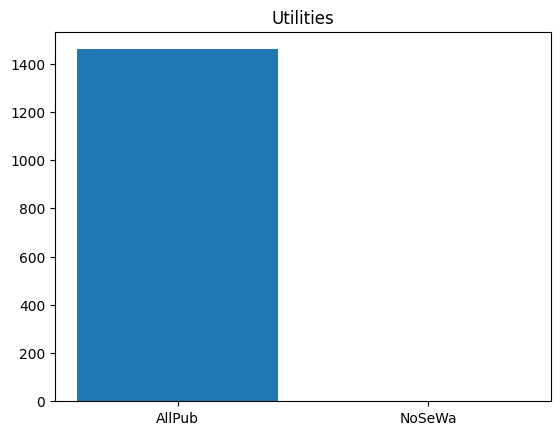

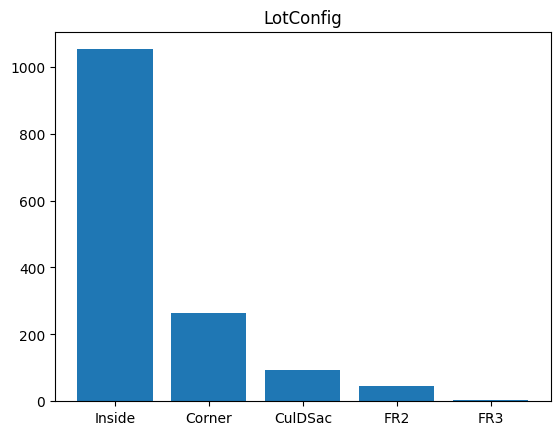

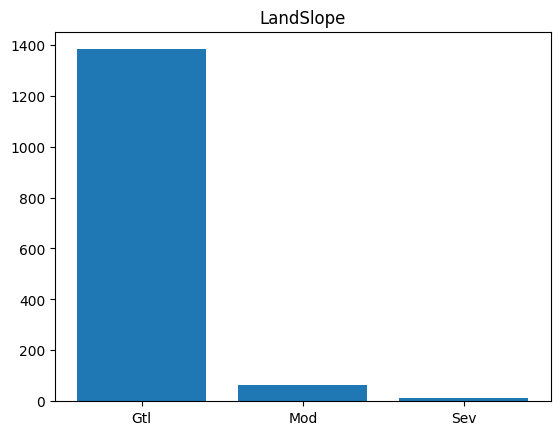

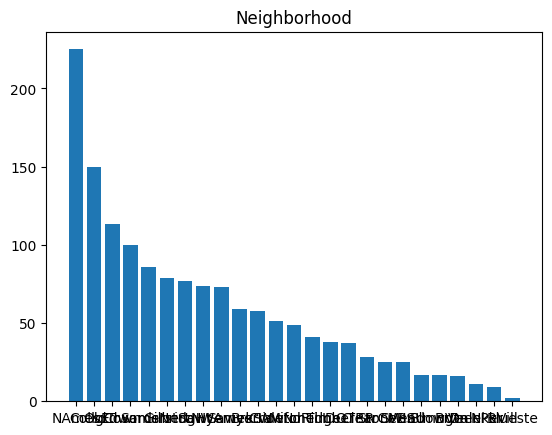

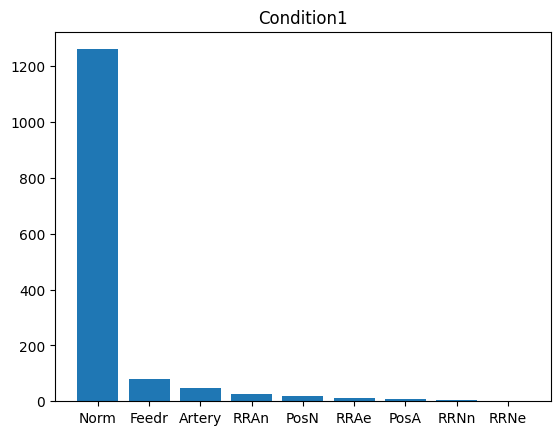

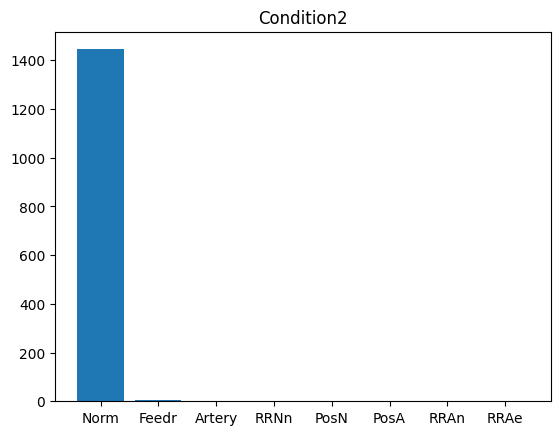

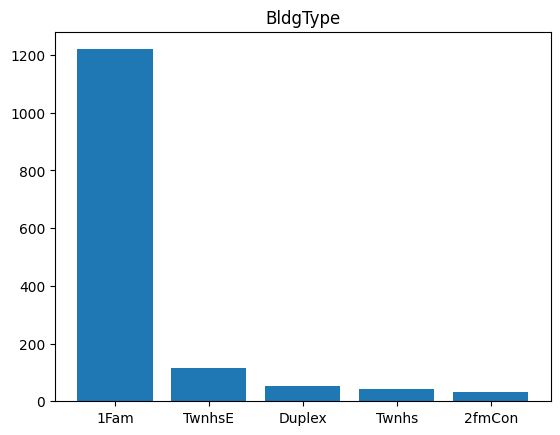

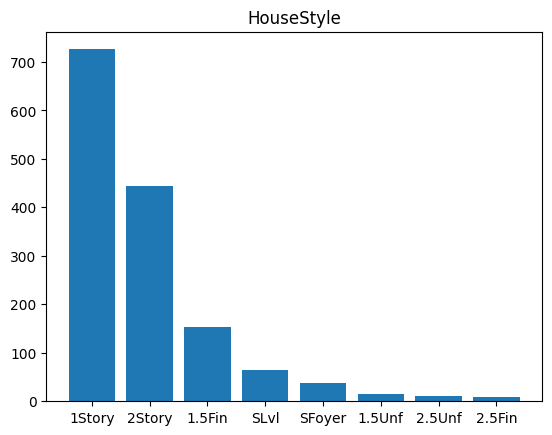

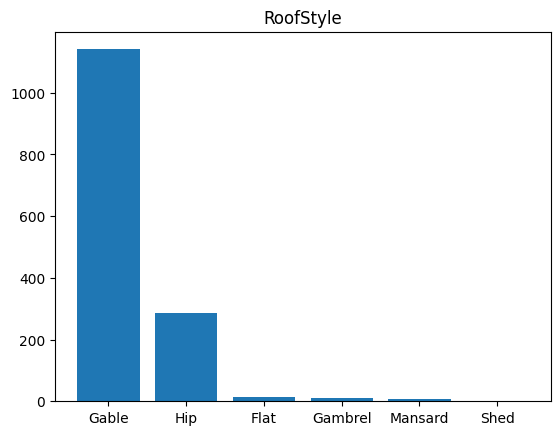

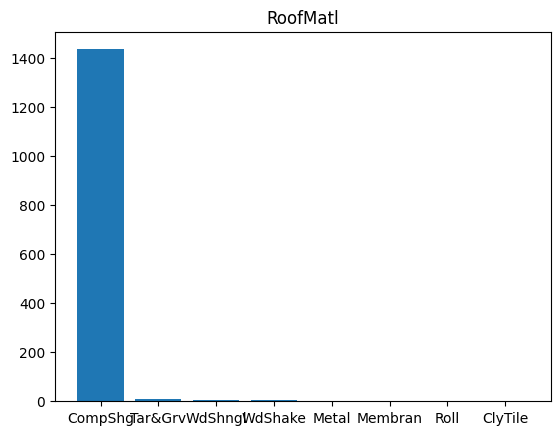

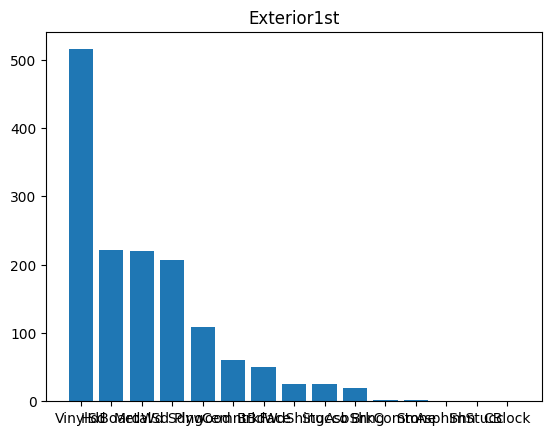

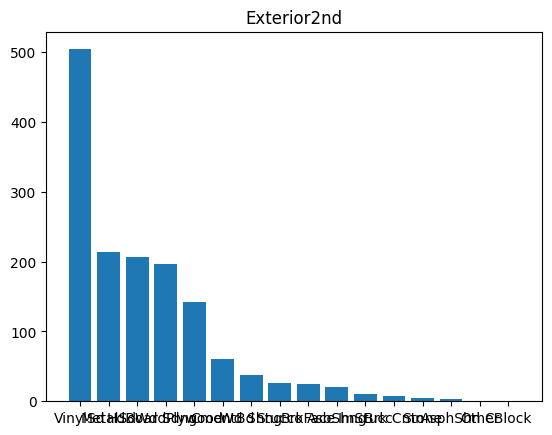

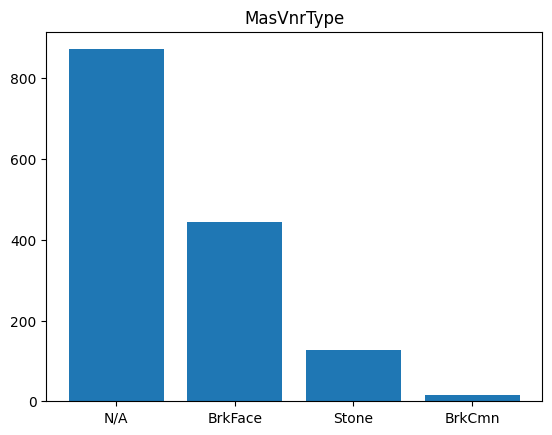

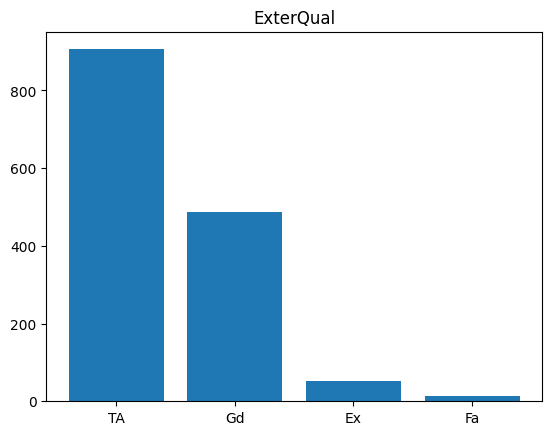

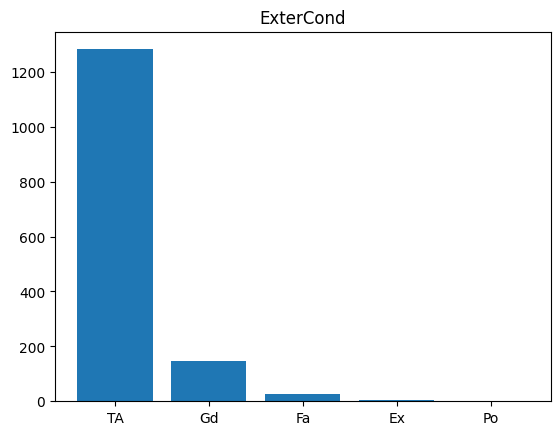

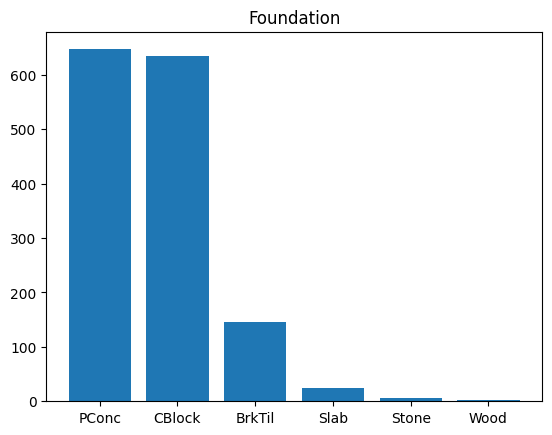

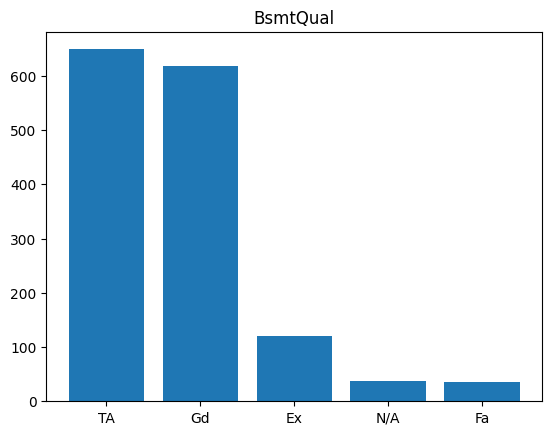

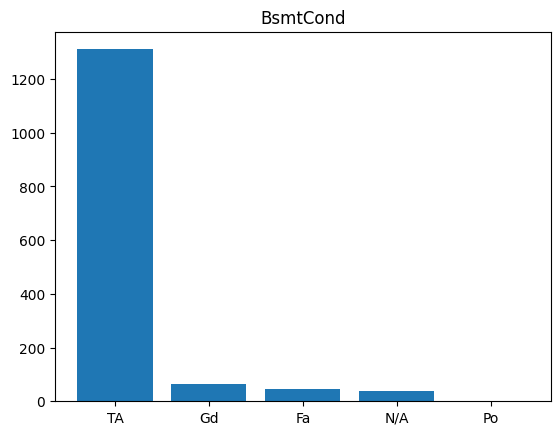

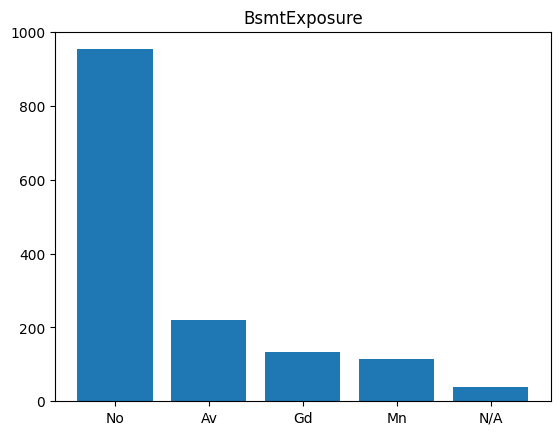

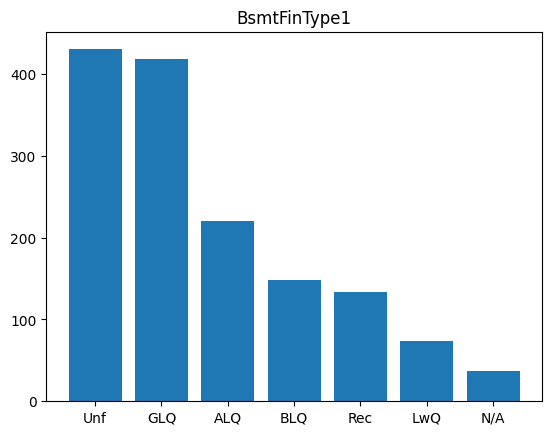

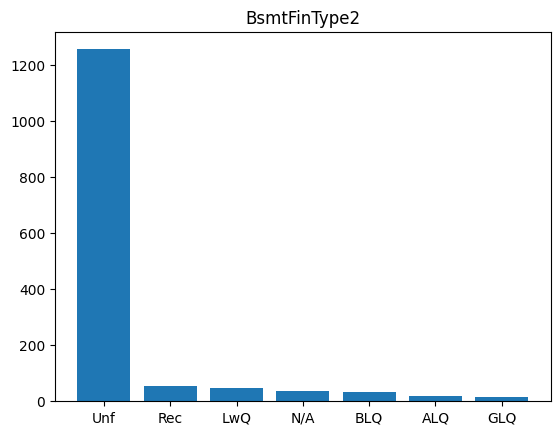

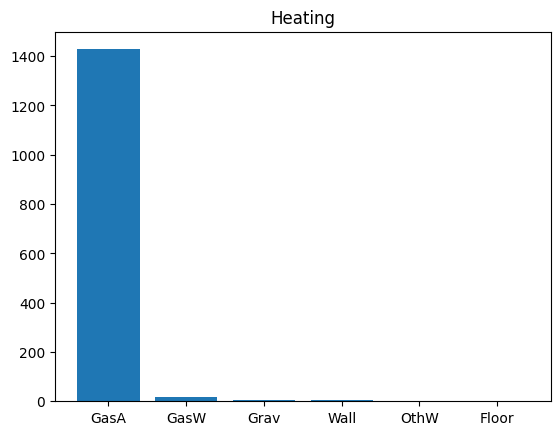

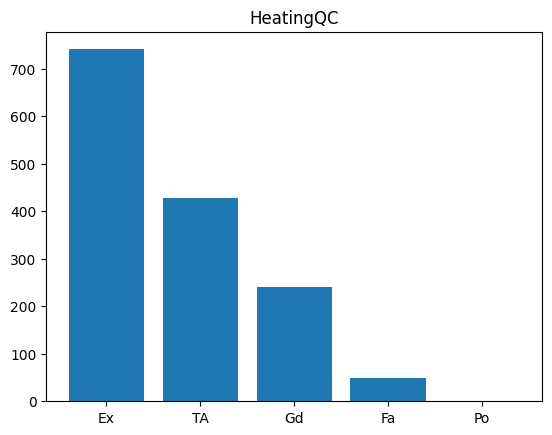

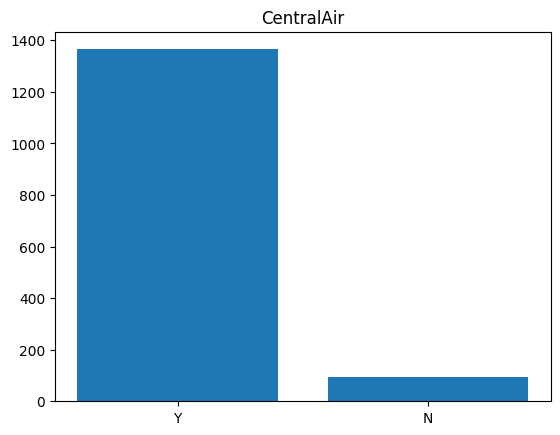

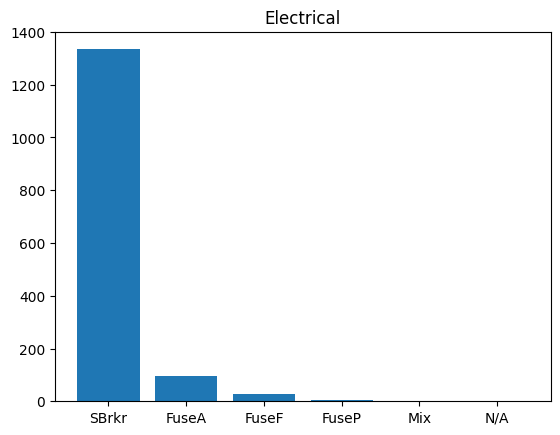

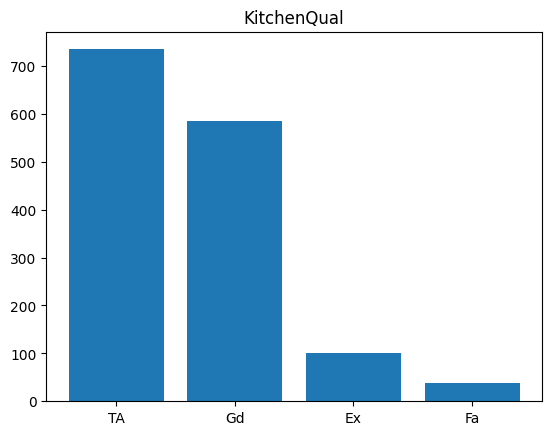

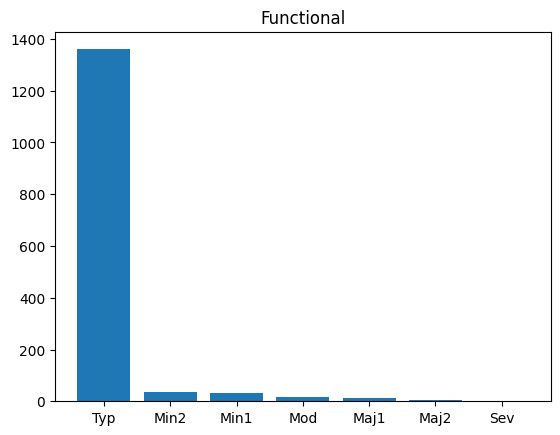

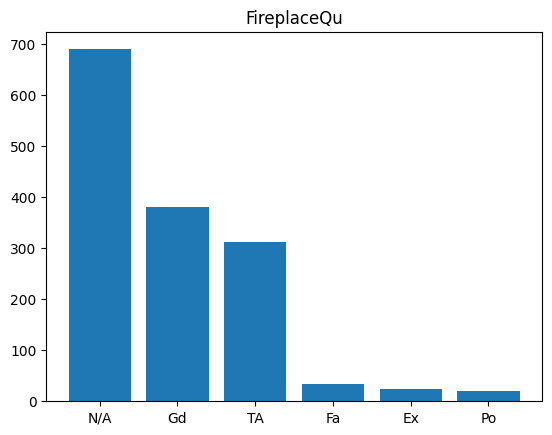

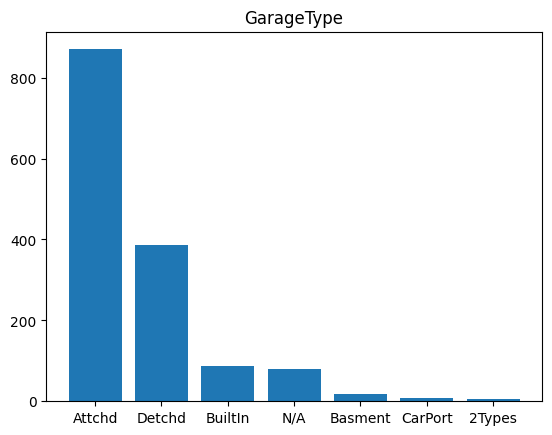

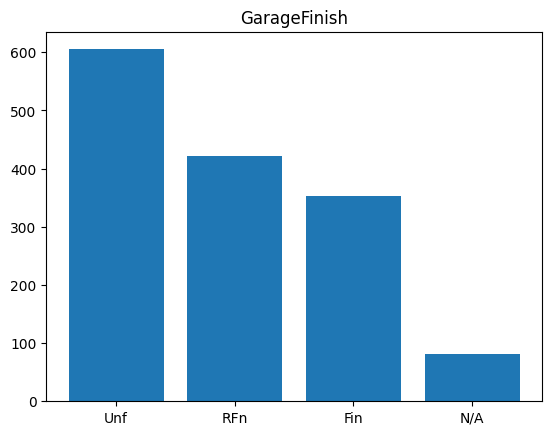

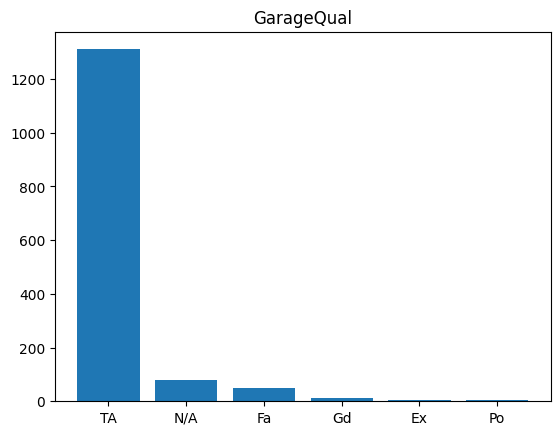

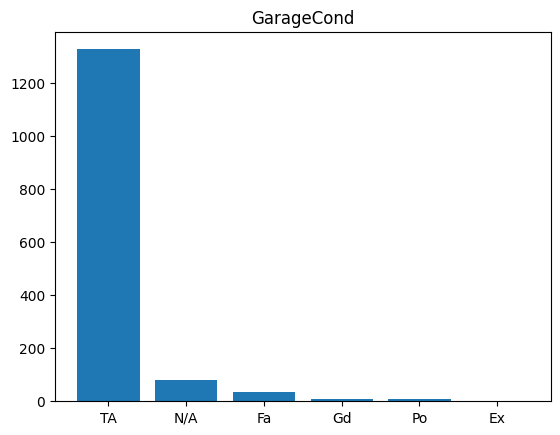

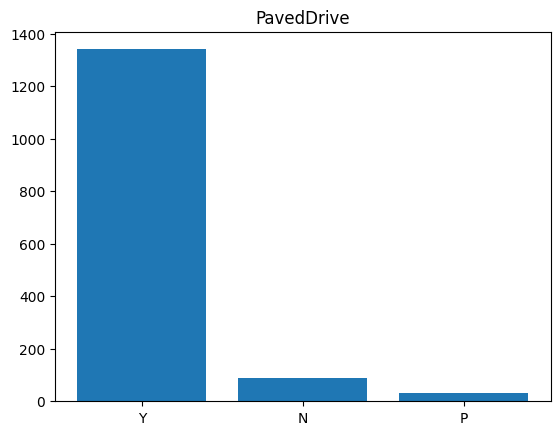

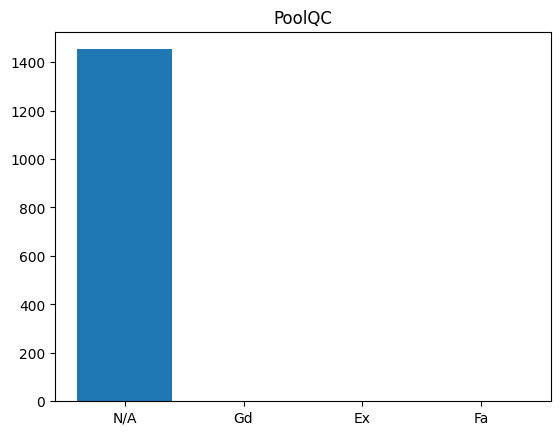

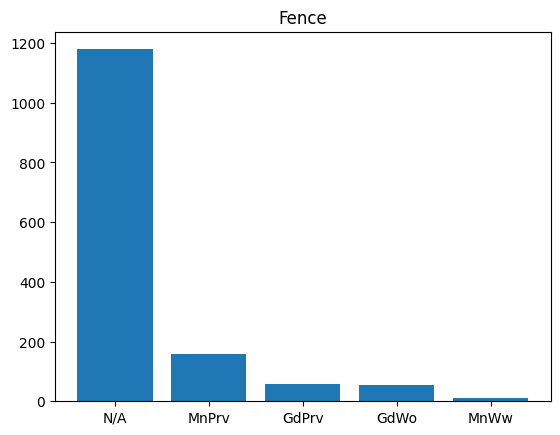

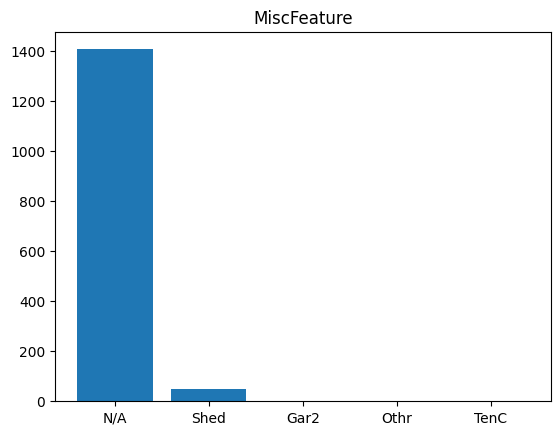

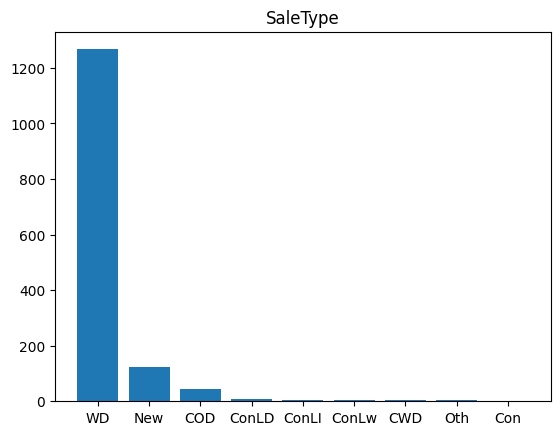

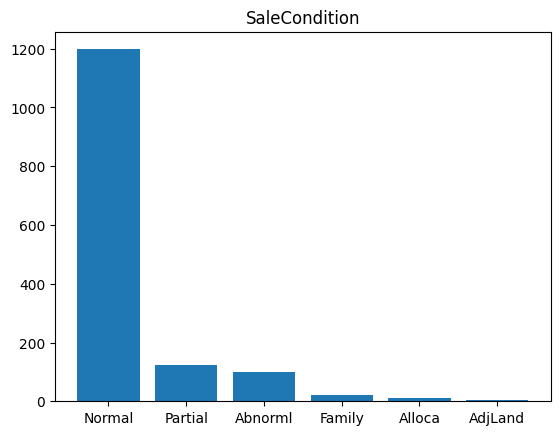

In [ ]:
for col in cat_cols:
  plt.bar(data[col].value_counts().index, data[col].value_counts())
  plt.title(col)
  plt.show()

**Analysis of the above distributions:**

Neighborhoods, Condition1, Condition2 are reliant on local (Iowa) information. Should be removed prior to final model.

Utilities could have been useful, but has too uneven of a distribution.

## Numerical Noisy Feature Removal

In [ ]:
# prompt: remove SalesPrice from X_train adn save it in y_train,split categorical and numerical feature from X_train data. now find correlation of all features in numerical data as compared to y_train, from x_train remove all features with low correlation from X_train
numerical_features = num_cols

# Separate labels from samples
y_train = data['SalePrice']

# Find and graph correlation between all features and the labels
targ_corr_num = {}
for feature in numerical_features:
  # Setting zeros in feature to NaN
  updated_data = cp.deepcopy(data[feature].replace(0, np.nan))

  # Calculate correlation without zeros
  pearson_woz = updated_data.corr(y_train)
  spearman_woz = updated_data.corr(y_train, method='spearman')

  # Calculate correlation with zeros
  pearson_wz = data[feature].corr(y_train)
  spearman_wz = data[feature].corr(y_train, method='spearman')

  # Save correlation into array
  targ_corr_num[feature] = (pearson_wz,spearman_wz, pearson_woz, spearman_woz)

# Observe features and remove using threshold on array
noisy_numerical_strong = []
noisy_numerical_weak = []
for feature in targ_corr_num:
  with_zero = False
  without_zero = False

  # Determining impact of inclusion/exclusion of zeros
  if(abs(targ_corr_num[feature][0]) < 0.3 and abs(targ_corr_num[feature][1]) < 0.3):
    with_zero = True
  if(abs(targ_corr_num[feature][2]) < 0.3 and abs(targ_corr_num[feature][3]) < 0.3):
    without_zero = True

  # Separating features by strong or weak impact of zeros
  if with_zero and without_zero:
    noisy_numerical_strong.append(feature)
  elif (not with_zero and without_zero) or (with_zero and not without_zero):
    noisy_numerical_weak.append(feature)

# Printing strong and weak noisy features
for feature in noisy_numerical_strong:
  print(feature, targ_corr_num[feature])
print("-------------------------------------------------------------------")
for feature in noisy_numerical_weak:
  print(feature, targ_corr_num[feature])

# Setting only to strong noise for now
noisy_numerical = noisy_numerical_strong

MSSubClass (-0.08428413512659531, 0.007192252911733476, -0.08428413512659531, 0.007192252911733476)
OverallCond (-0.07785589404867803, -0.12932494660061317, -0.07785589404867803, -0.12932494660061317)
BsmtFinSF2 (-0.011378121450215125, -0.03880613204589418, 0.19895609430836594, 0.11843388567766258)
BsmtUnfSF (0.21447910554696892, 0.185196629420762, 0.1692610004951418, 0.11282241442039748)
BsmtFullBath (0.22712223313149382, 0.22512486719612368, 0.01143916334040866, 0.024792357595010216)
BsmtHalfBath (-0.016844154297359016, -0.012188876310787316, -0.028834567185481722, -0.016703554806725977)
BedroomAbvGr (0.16821315430073988, 0.23490671789027862, 0.18093669310848812, 0.24029795563186981)
KitchenAbvGr (-0.13590737084214122, -0.1648257549850205, -0.1392006921778579, -0.16924325951926172)
EnclosedPorch (-0.12857795792595653, -0.2183936205521982, 0.24127883630117508, 0.24740585729184555)
3SsnPorch (0.04458366533574846, 0.06544021620062833, 0.06393243256889079, 0.2291441132422282)
MiscVal (-0

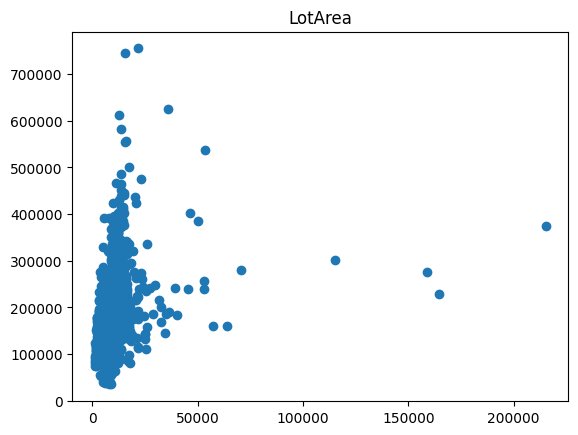

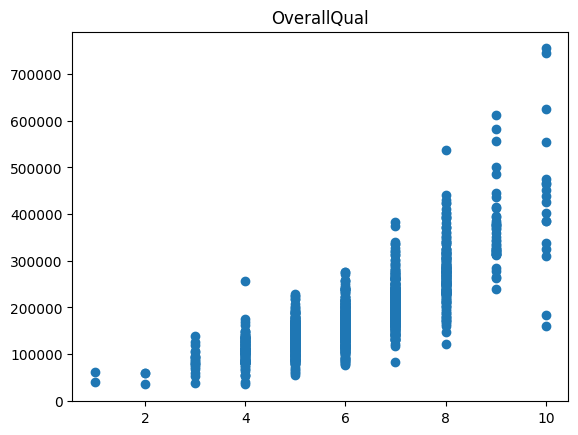

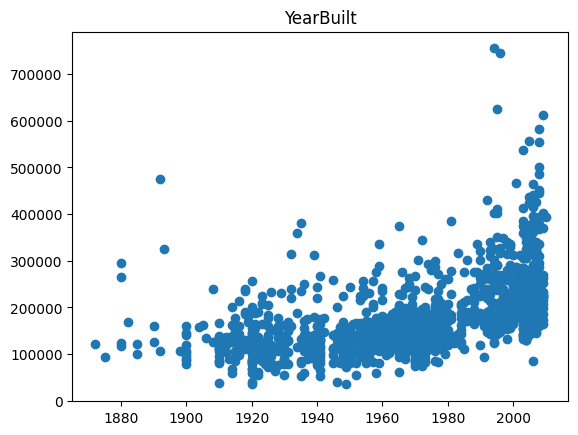

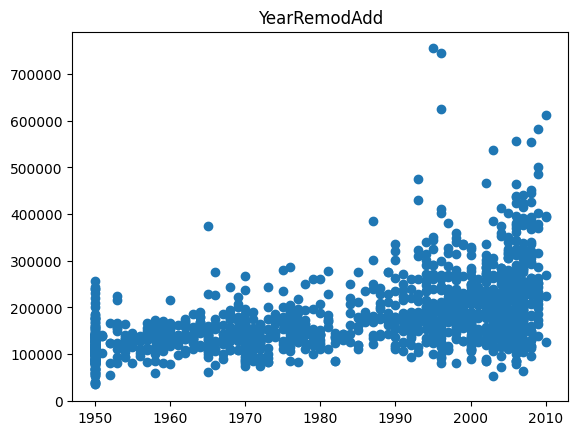

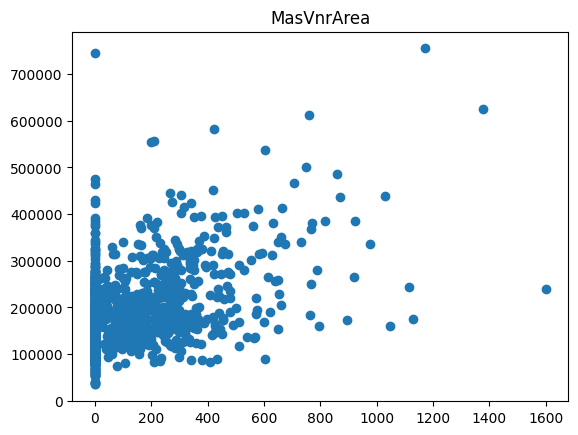

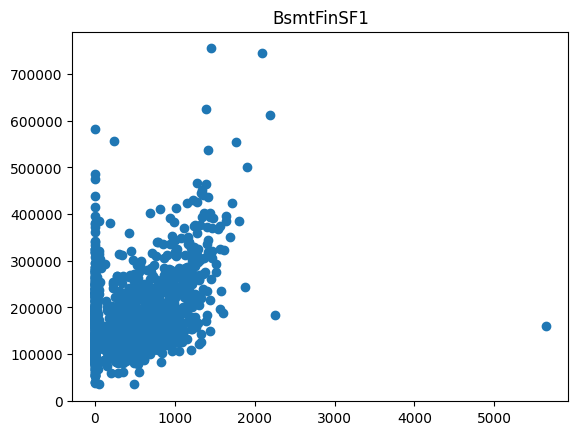

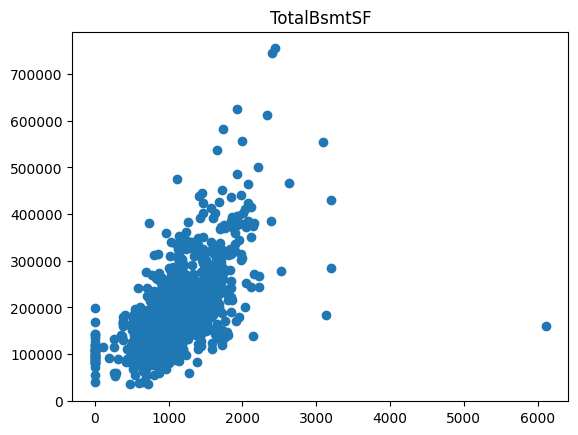

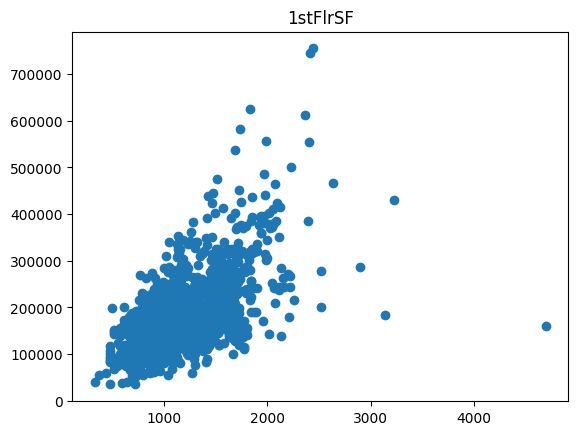

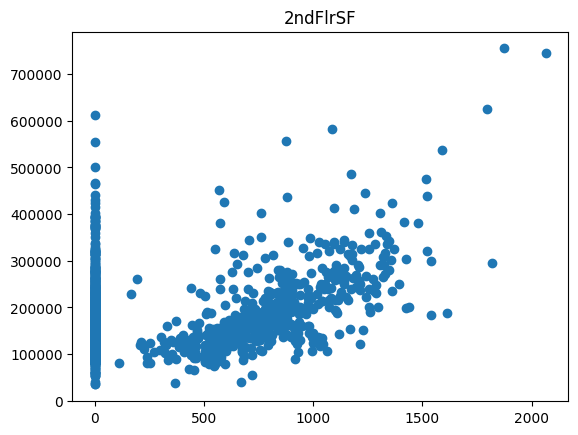

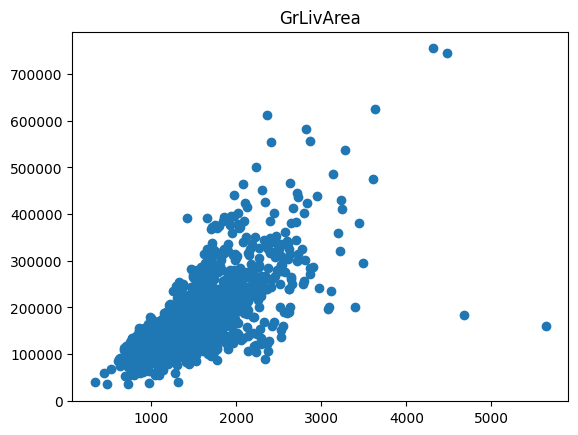

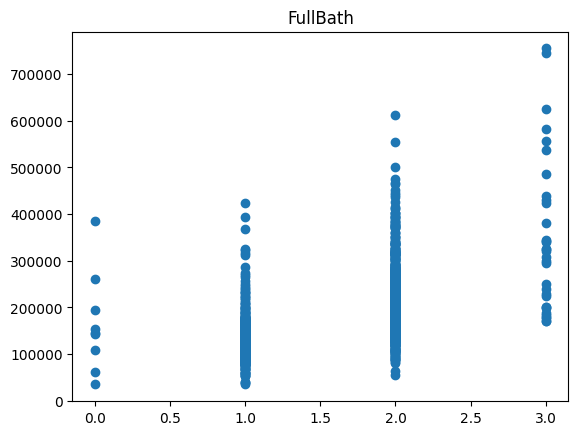

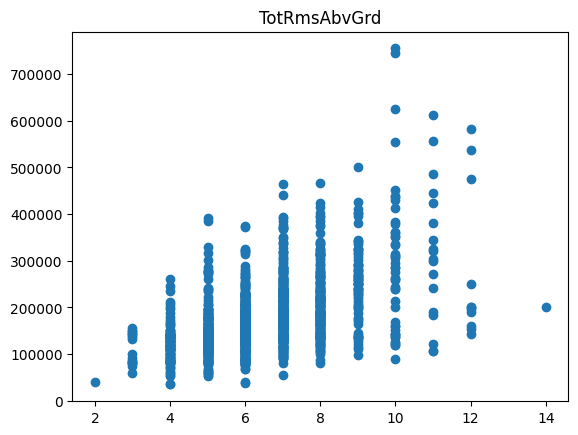

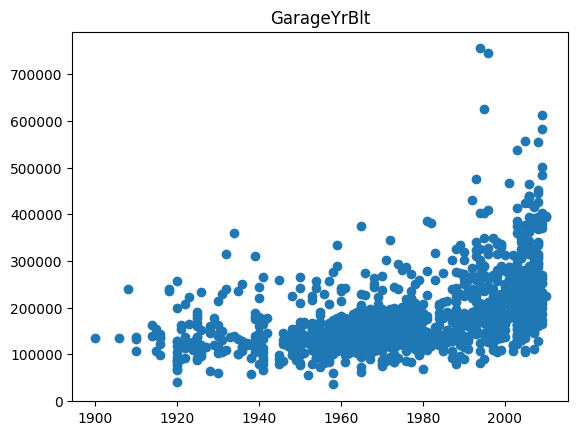

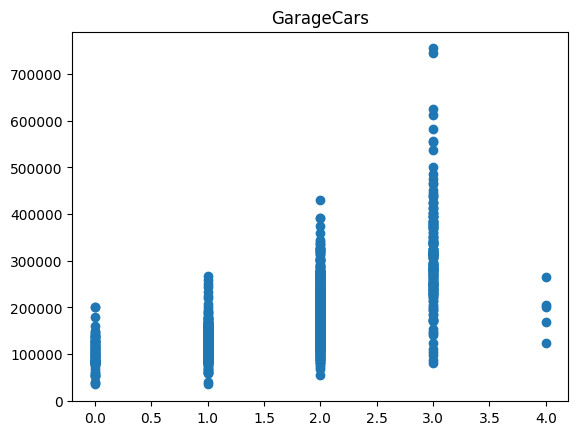

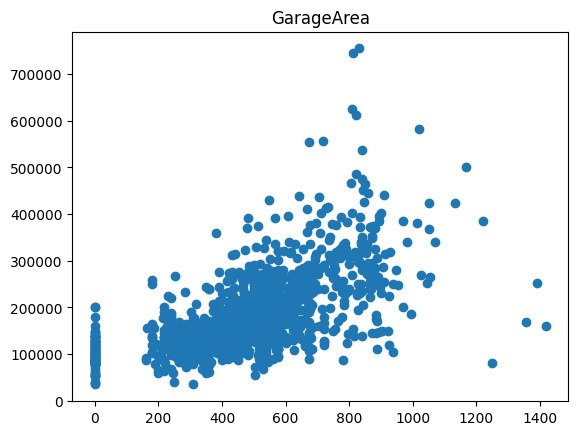

-------------------------------------------------------------------


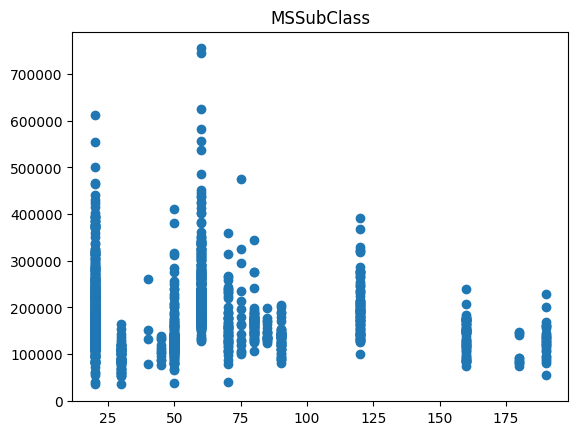

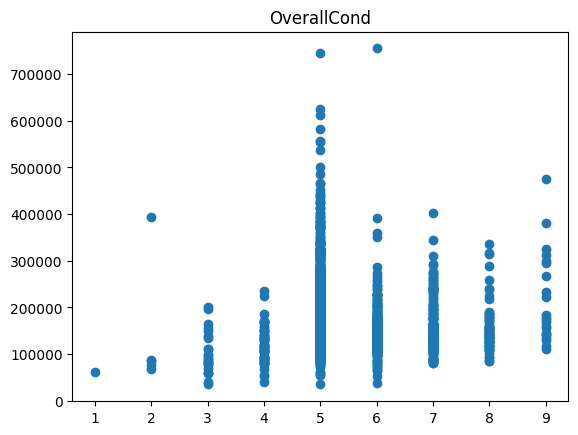

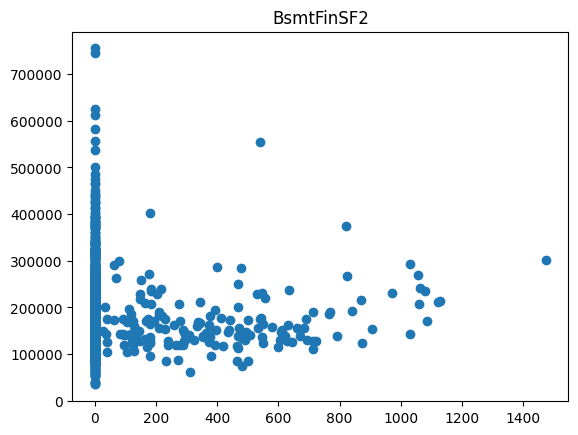

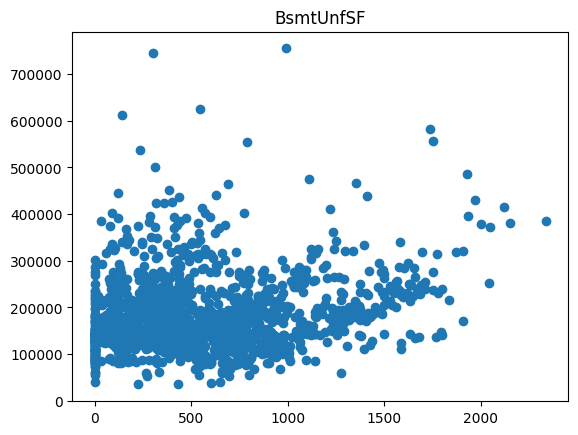

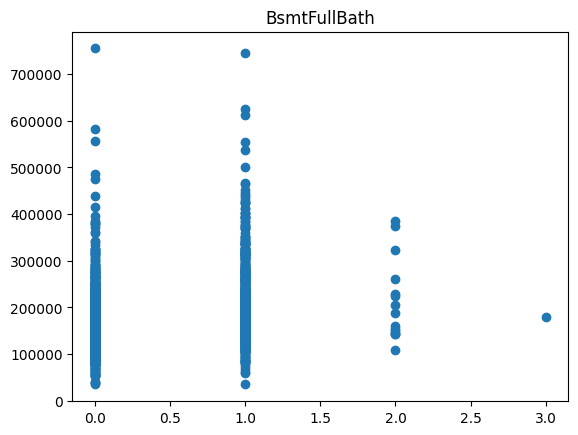

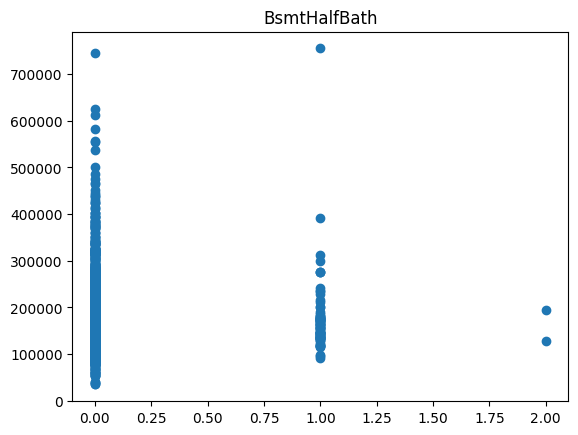

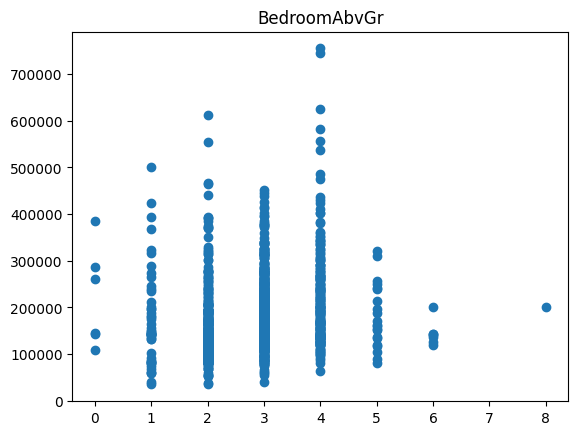

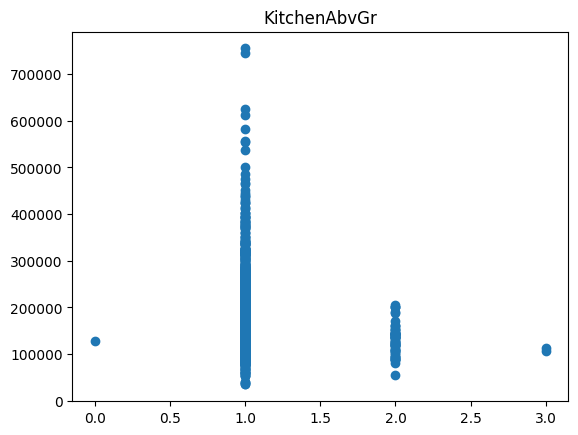

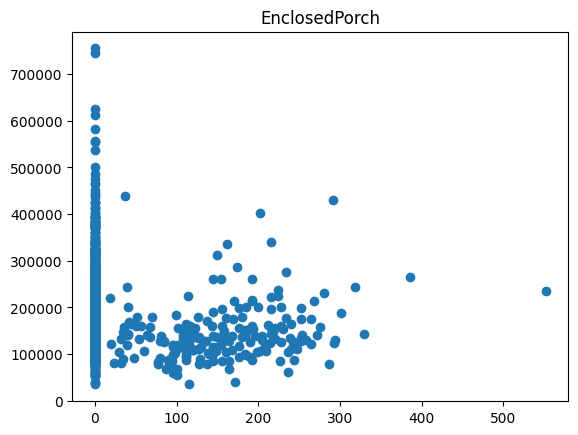

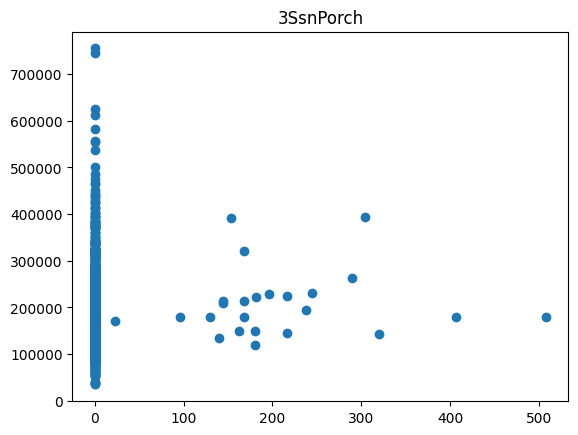

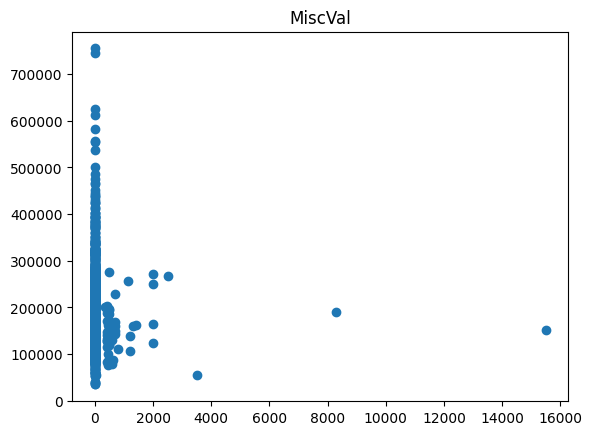

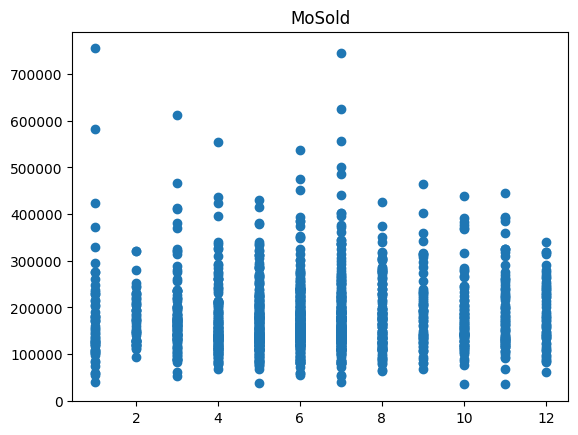

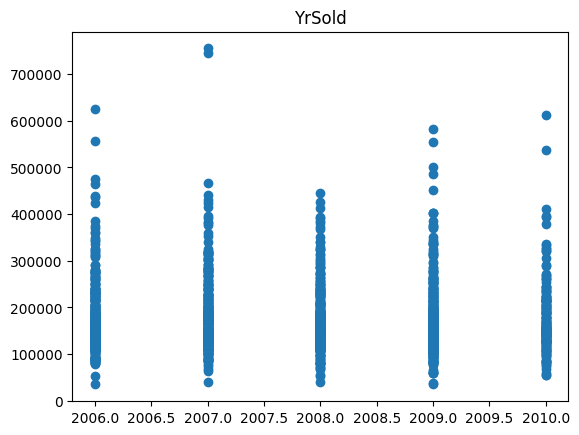

-------------------------------------------------------------------


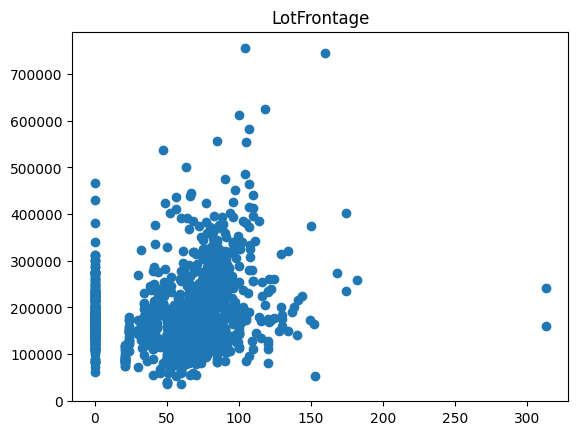

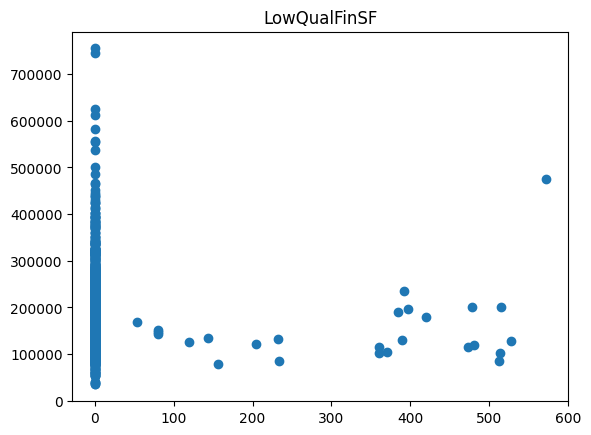

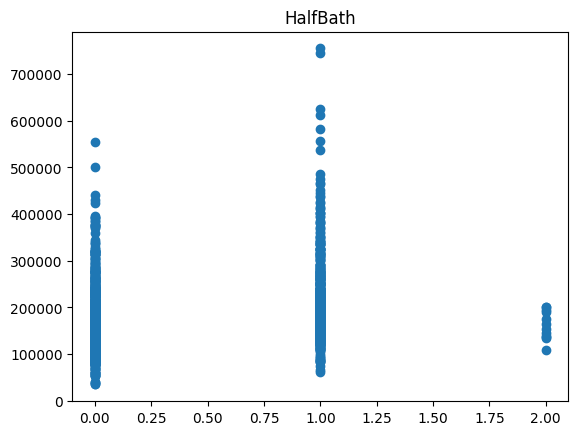

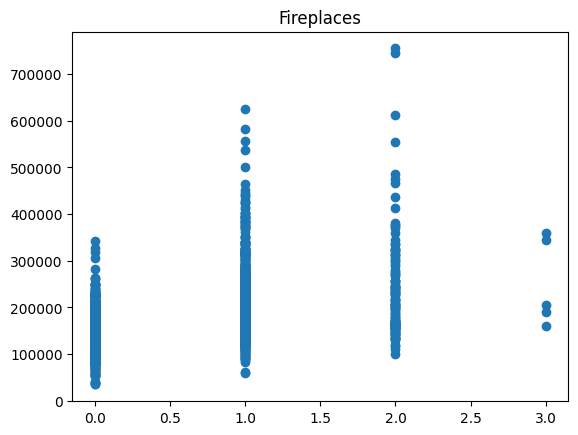

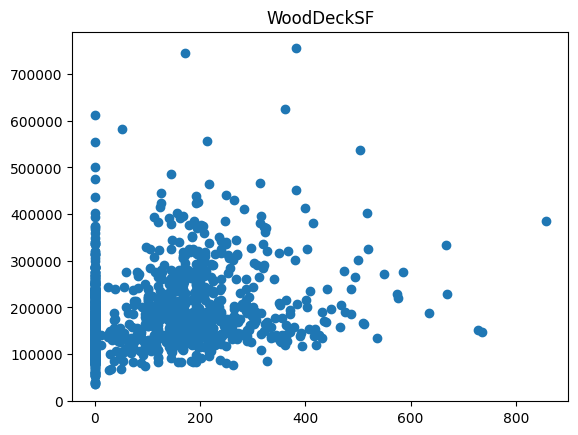

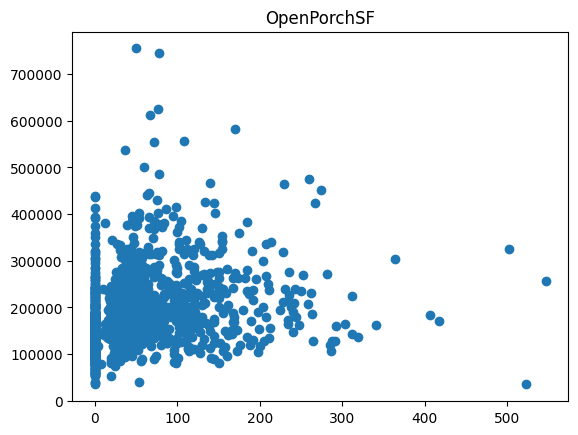

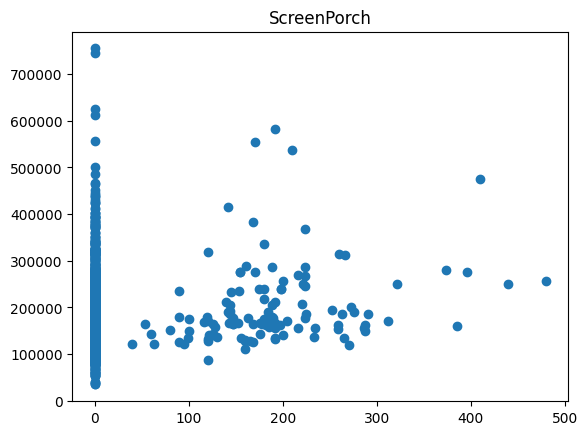

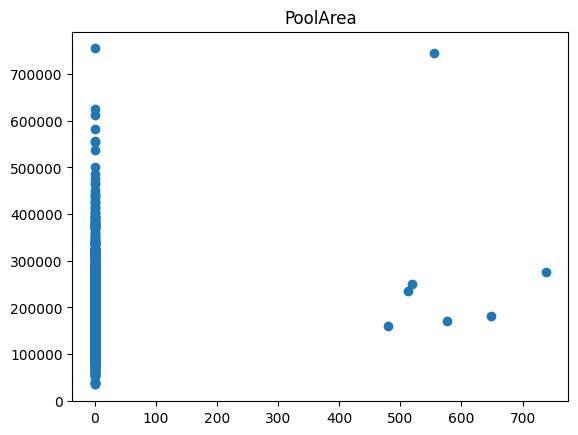

In [ ]:
for col in numerical_features:
  if (col not in noisy_numerical_strong) and (col not in noisy_numerical_weak):
    plt.scatter(data[col], y_train)
    plt.title(col)
    plt.show()
print("-------------------------------------------------------------------")
for col in noisy_numerical_strong:
  plt.scatter(data[col], y_train)
  plt.title(col)
  plt.show()
print("-------------------------------------------------------------------")
for col in noisy_numerical_weak:
  plt.scatter(data[col], y_train)
  plt.title(col)
  plt.show()

**Analysis of the above**

Halfbath may not be correctly indicative of real-world since higher half-bath count would typically lead to higher prices. However, this could be due to absense of full bathrooms?

Garage Cars may also be fairly noisy, but it may be that more rural homes have higher amount of cars instead.

YearBuilt and YearRemodAdd may both be too far in the past to utilize (right?)
____________________________________________

MsSubClass is more categorical and shouldn't be unincluded from the dataset due to a numerical correlation assumption.

Overall Condition looks more linear.

Year-sold won't be very applicable to the model that we are planning on training.

## Categorical Noisy Feature Removal

In [ ]:
# For categorical features
categorical_features = cat_cols
targ_corr_cat = {}

for feature in categorical_features:
  # Group the target variable by the categorical feature
  grouped_target = y_train.groupby(data[feature])

  # Perform ANOVA
  f_statistic, p_value = f_oneway(*[grouped_target.get_group(group) for group in grouped_target.groups])

  # Save results
  targ_corr_cat[feature] = (f_statistic, p_value)

# Observe features and remove using a threshold on p-value
noisy_categorical = []
for feature in targ_corr_cat:
  if targ_corr_cat[feature][1] > 0.01:  # Adjust threshold as needed
    print(feature, targ_corr_cat[feature])
    noisy_categorical.append(feature)

Street (2.4592895583691994, 0.11704860406782483)
Utilities (0.29880407484898486, 0.5847167739689381)
LandSlope (1.9588170374149438, 0.1413963584114019)
Condition2 (2.0738986215227877, 0.043425658360948464)
MiscFeature (2.593622339924057, 0.0350036718754261)


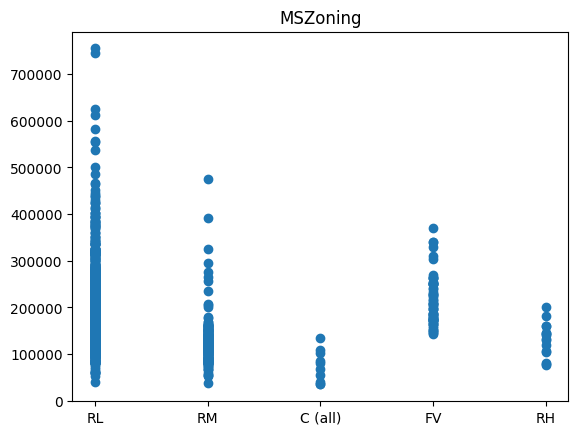

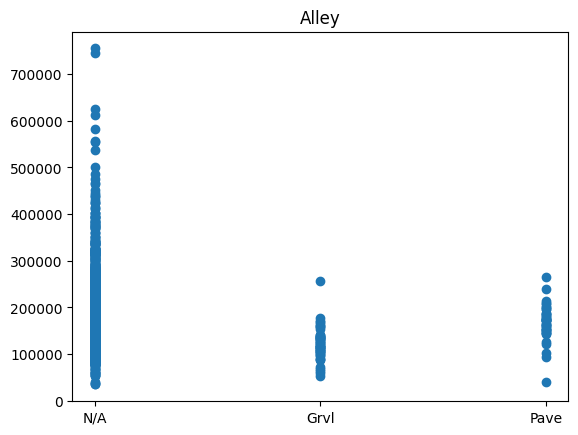

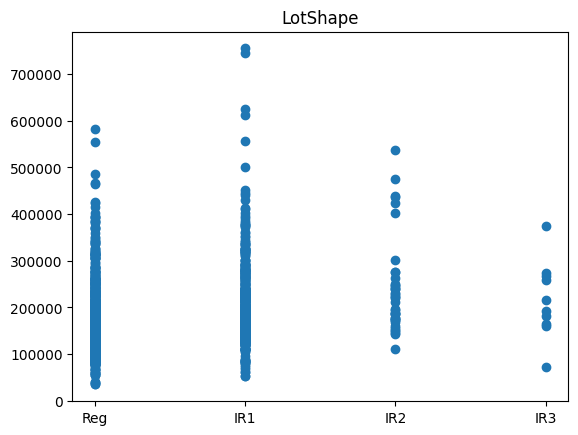

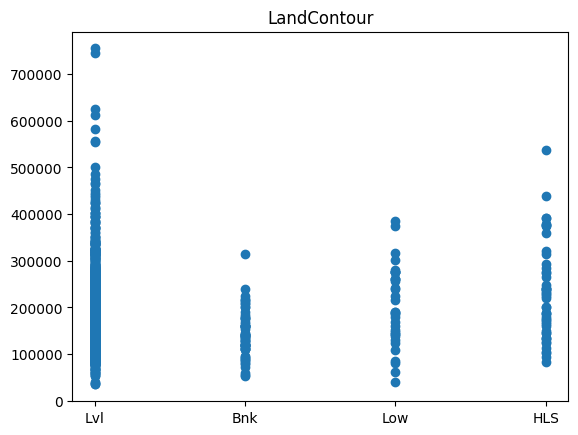

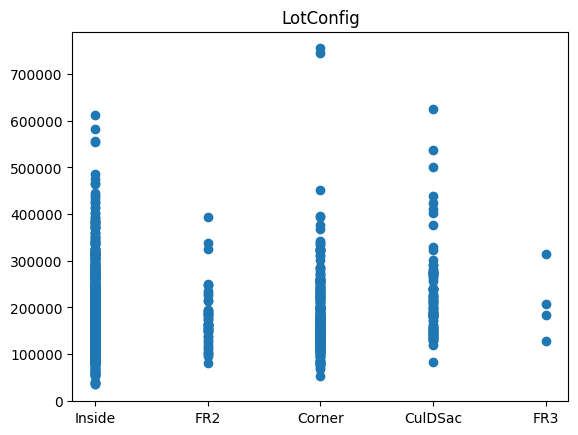

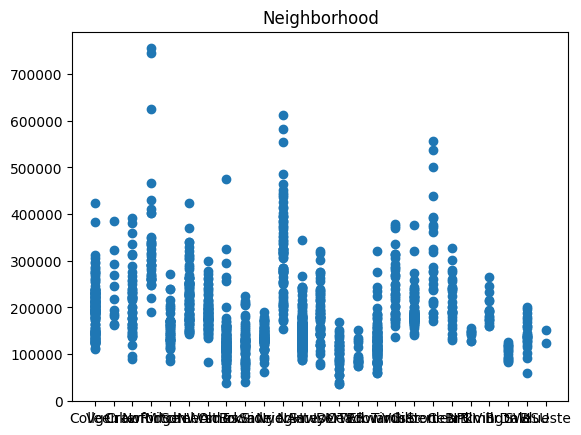

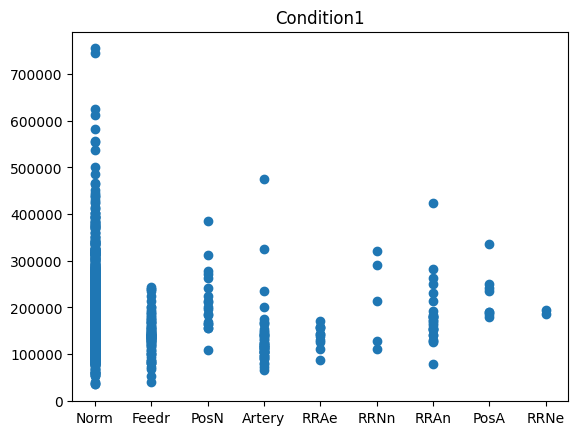

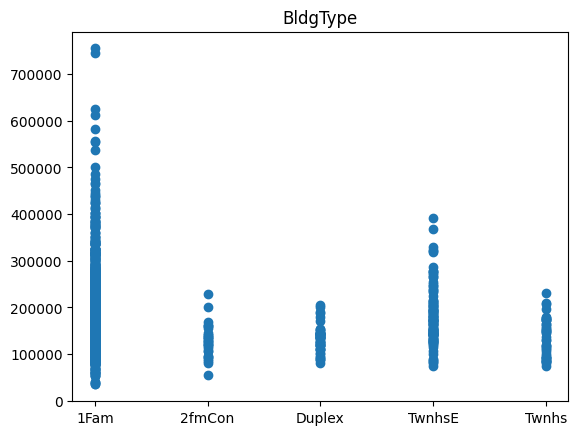

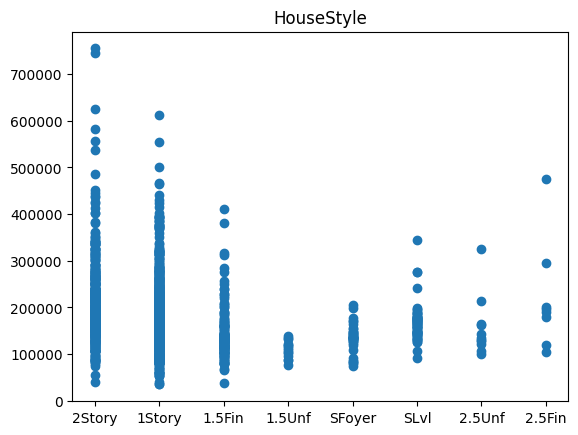

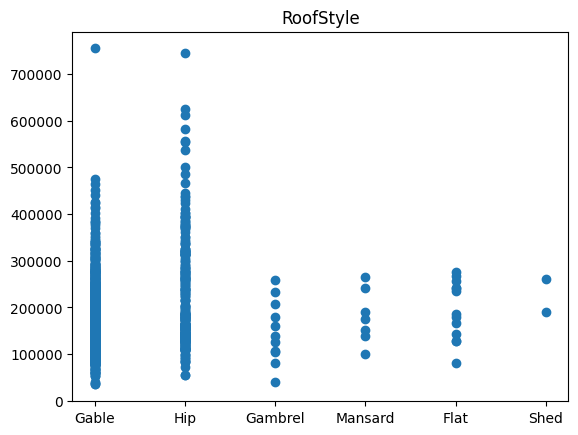

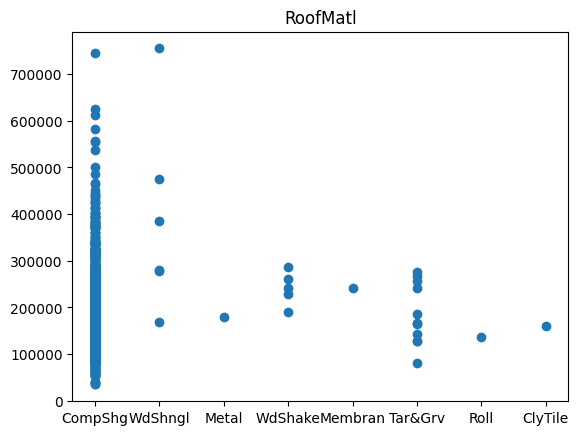

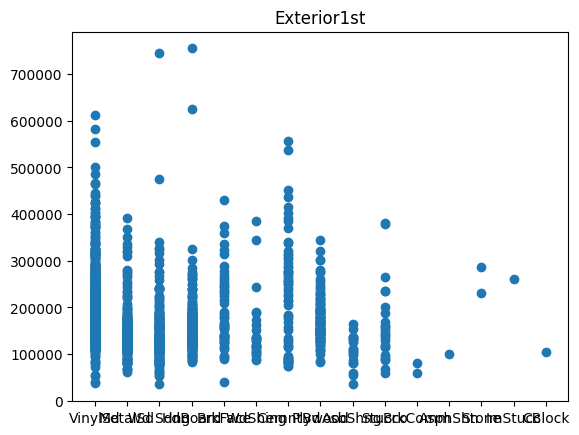

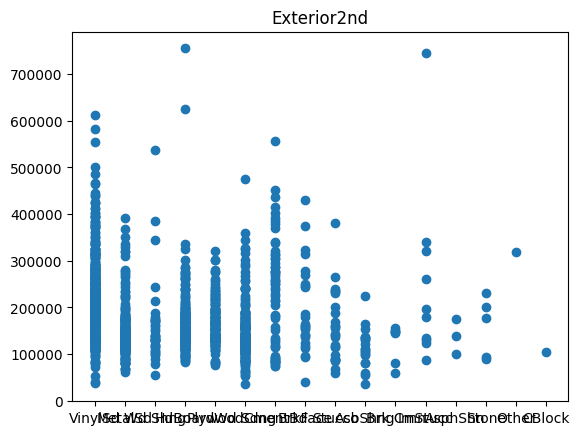

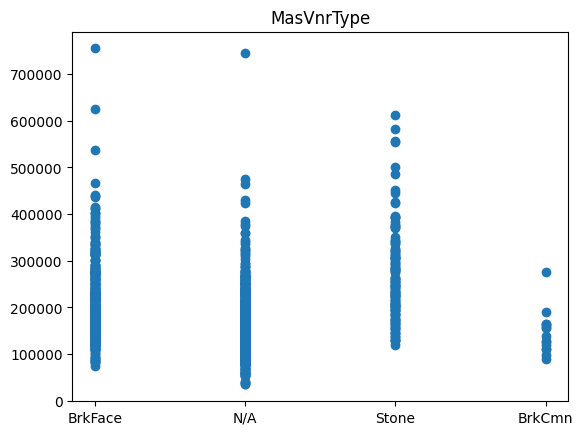

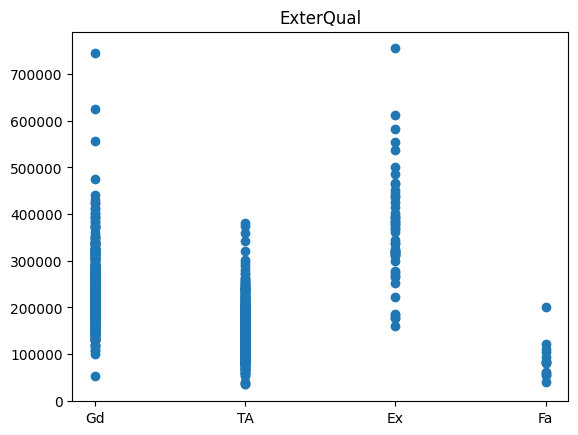

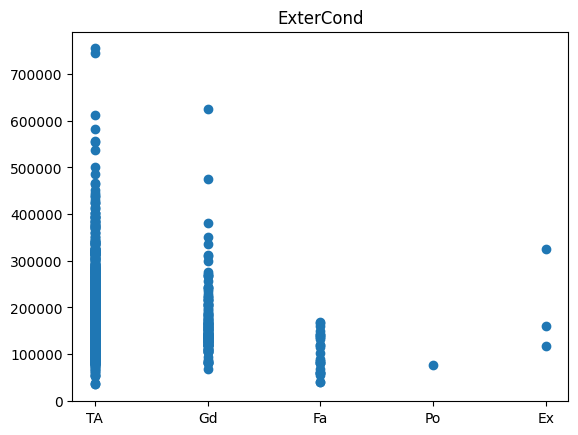

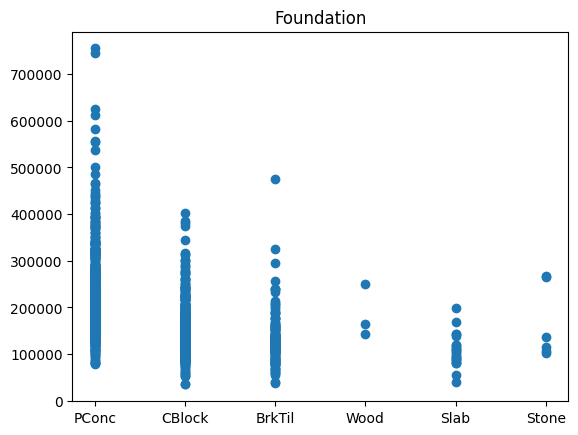

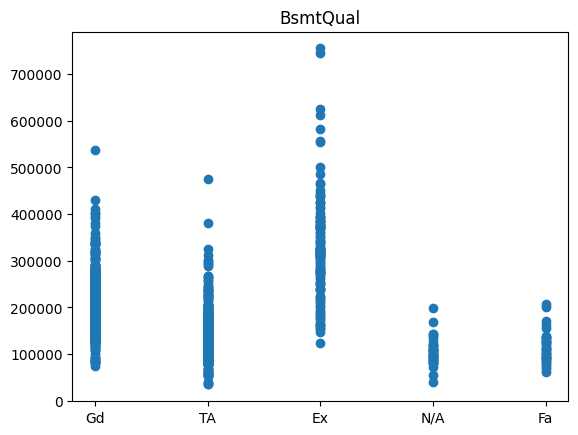

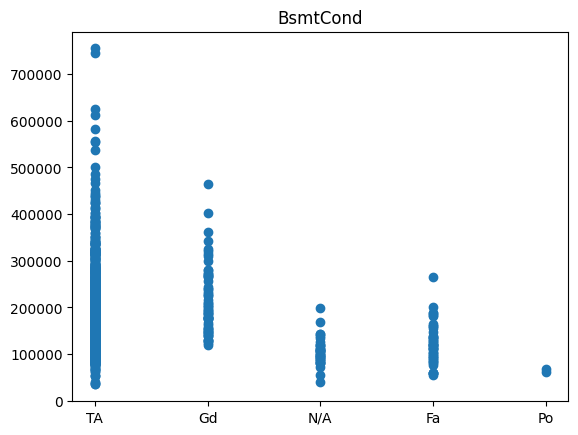

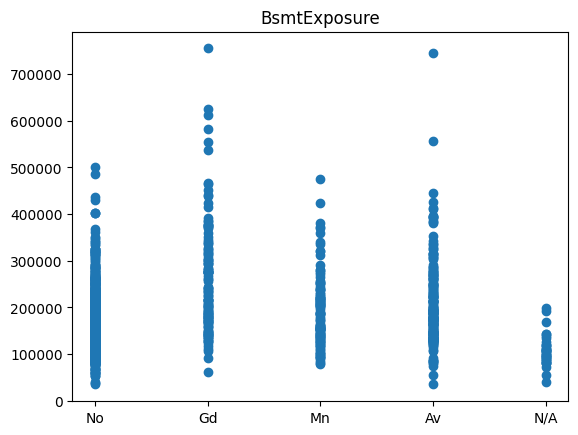

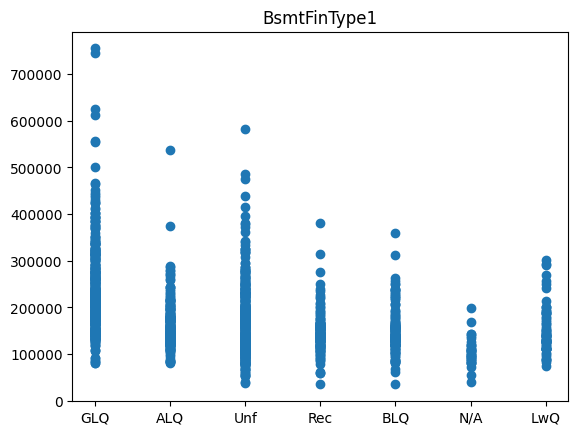

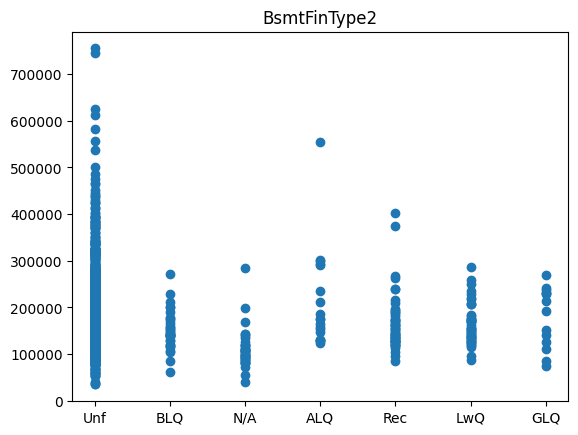

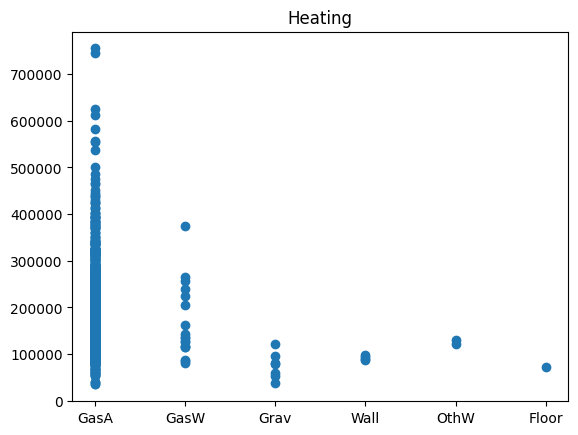

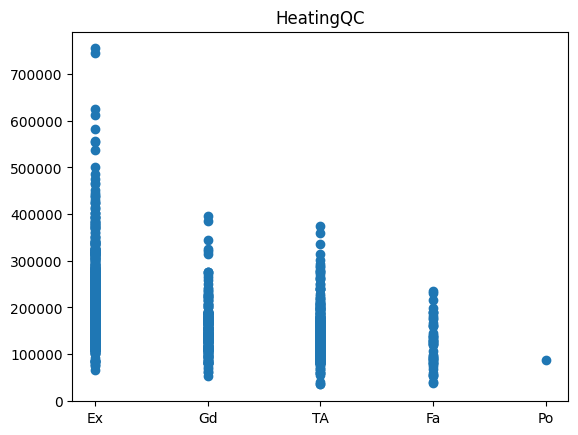

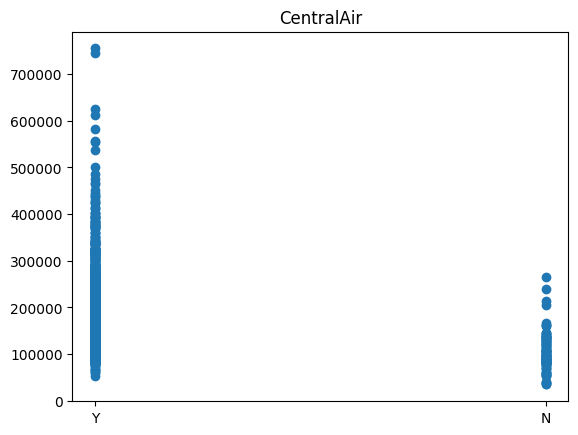

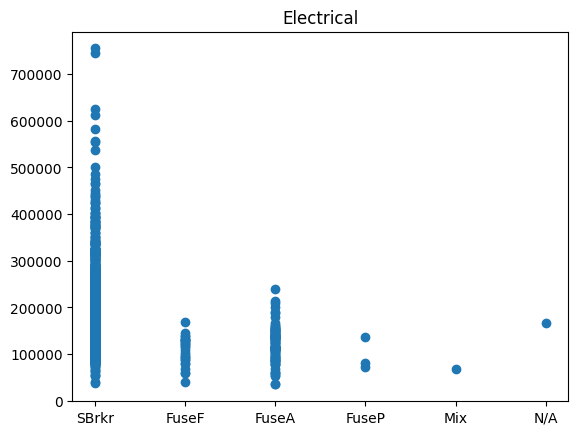

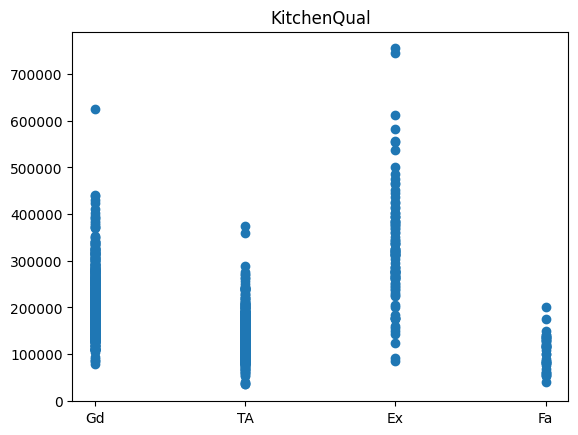

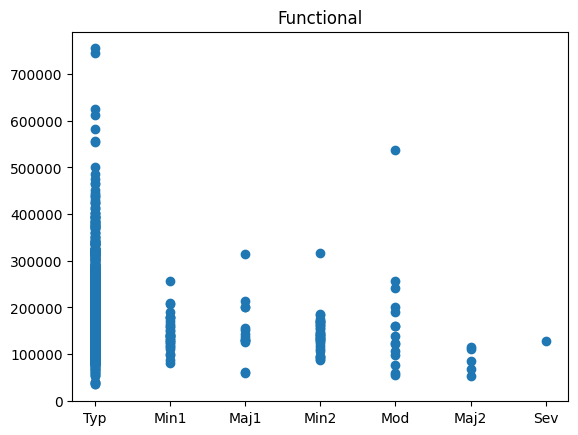

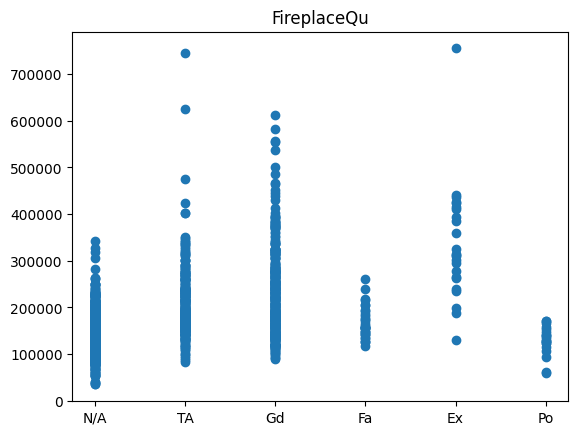

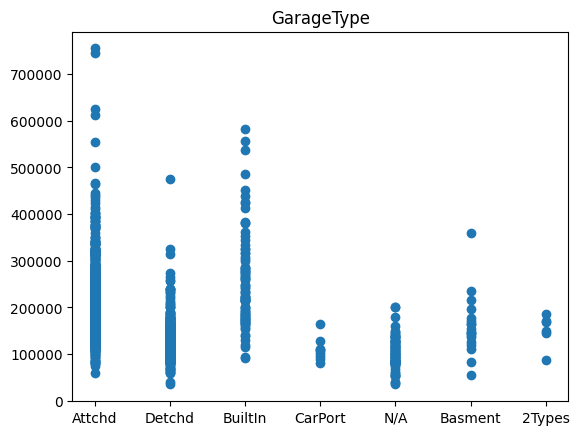

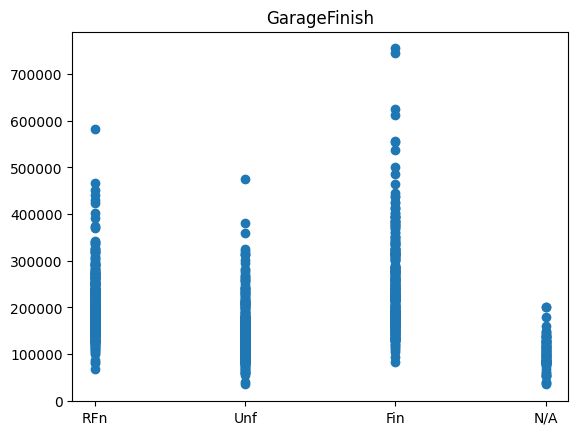

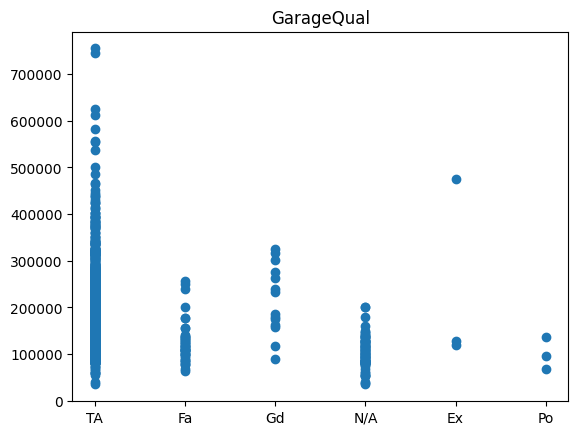

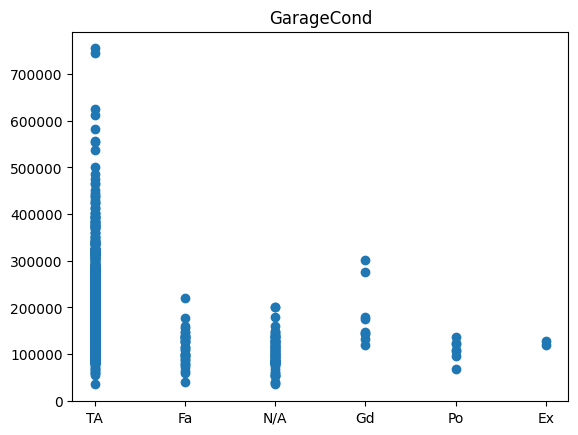

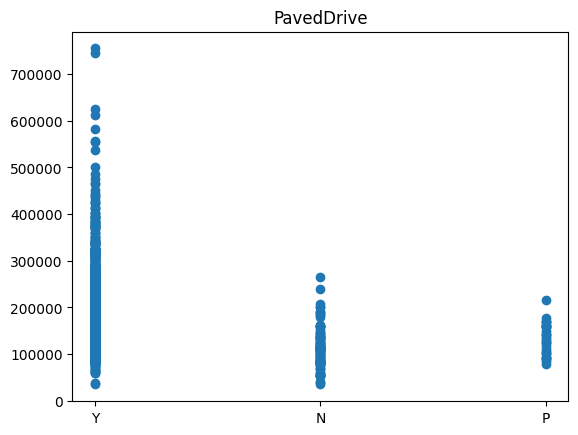

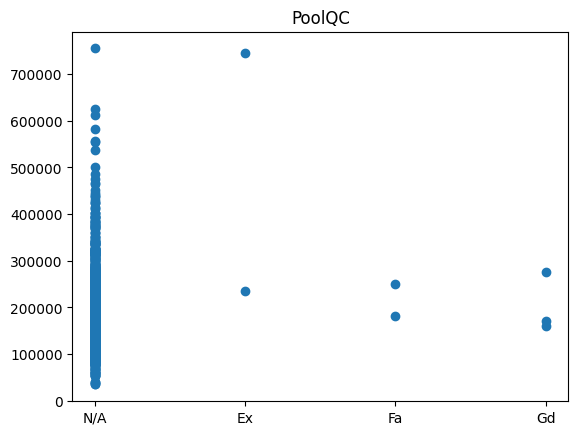

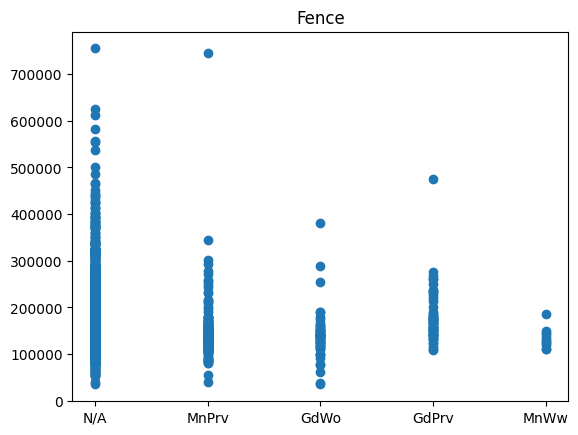

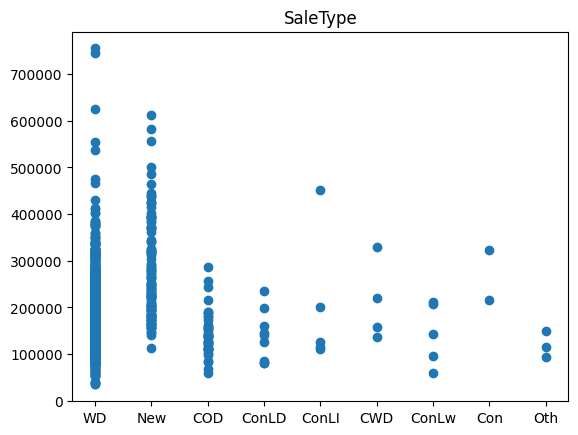

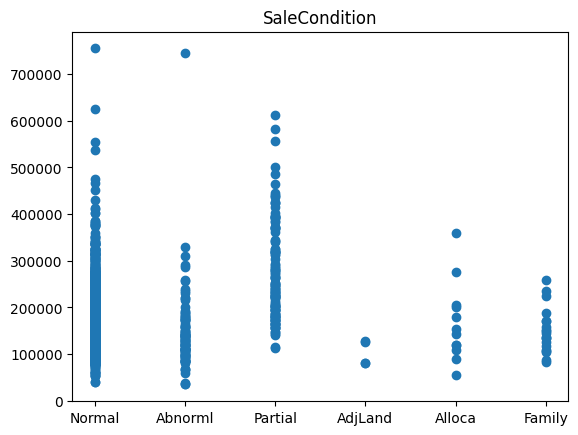

-------------------------------------------------------------------


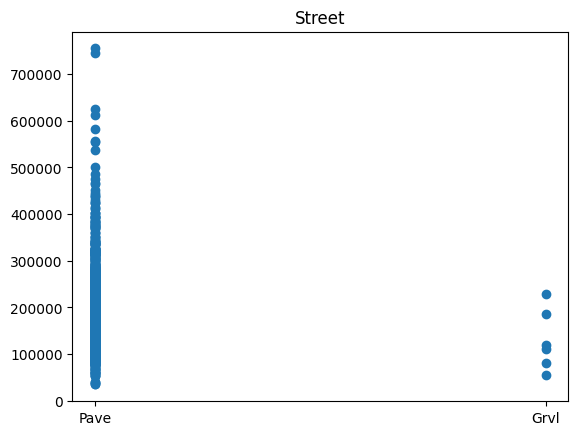

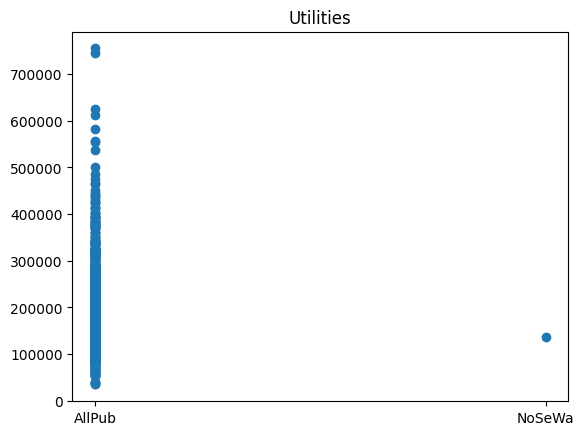

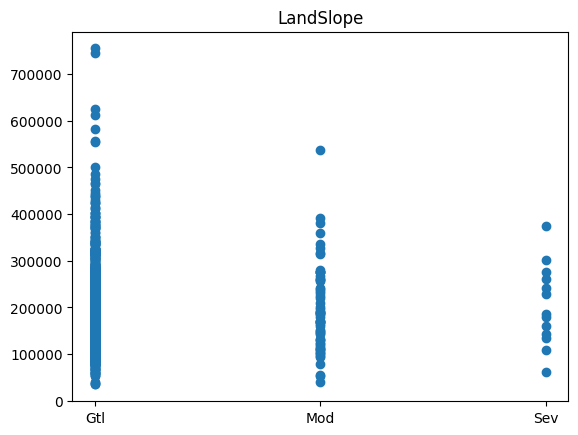

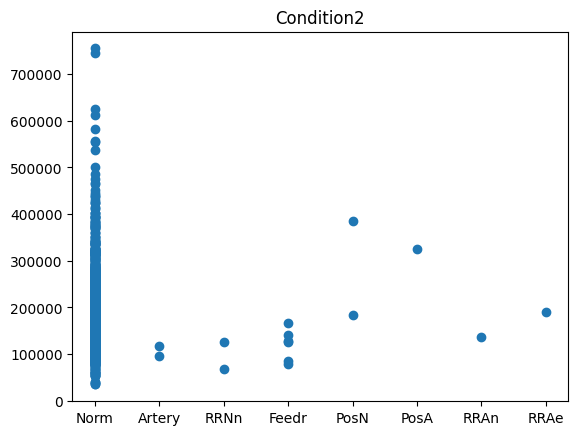

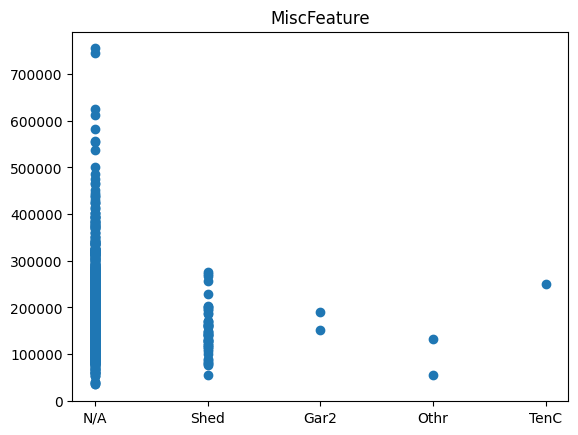

In [ ]:
for col in categorical_features:
  if col not in noisy_categorical:
    plt.scatter(data[col].astype(str), y_train)
    plt.title(col)
    plt.show()
print("-------------------------------------------------------------------")
for col in noisy_categorical:
  plt.scatter(data[col].astype(str), y_train)
  plt.title(col)
  plt.show()

**Analysis of the above**

Electrical does have one NaN point that will need to be handled.

GarageCond and GarageQual appear to not be indicative of the "real-world."

Fence does not appear to be a very good distribution.

____________________________________________

Land Slope appears to be informative despite being considered "noise."

## Feature vs Feature

In [ ]:
# Split numerical from categorical features
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
num_cols = data.select_dtypes(include=['number']).columns.tolist()

# Create copies of lists for tracking
cat_cols_copy = cp.deepcopy(cat_cols)
num_cols_copy = cp.deepcopy(num_cols)

# Dictionaries for tracking results
cat_corr = {}
num_corr = {}

In [ ]:
# Use chi-squared analysis on categorical features
for col1 in cat_cols:
  for col2 in cat_cols_copy:

    # No need to compare the same feature
    if col1 == col2:
      continue

    # Contingency table
    contingency_tbl = pd.crosstab(data[col1], data[col2])

    # Ensure table has values (i.e. is not empty)
    if contingency_tbl.size == 0:
      # Assigning default values
      cat_corr[(col1, col2)] = (0, 1)
      continue

    # Perform chi-squared analysis
    chi, p, dof, expected = chi2_contingency(contingency_tbl)

    # Save results
    cat_corr[(col1, col2)] = (chi, p)

  # Remove col from copied list
  if col1 in cat_cols_copy:
    cat_cols_copy.remove(col1)

In [ ]:
# Use correlation analysis on numerical features
for col1 in num_cols:
  for col2 in num_cols_copy:

    # No need to compare the same feature
    if col1 == col2:
      continue

    # Calculate correlation
    pearson_temp = data[col1].corr(data[col2])
    spearman_temp = data[col1].corr(data[col2], method='spearman')

    # Save correlation into array
    num_corr[(col1, col2)] = (pearson_temp, spearman_temp)

  # Remove col from copied list
  if col1 in num_cols_copy:
    num_cols_copy.remove(col1)

In [ ]:
# # Finding low p-values
# for key in cat_corr:
#   if cat_corr[key][1] < 0.05:
#     print(key, cat_corr[key])

# # Adding a separator so that it's clear which are cat vs num
# print("---------------------------------------------------------------")

# # Finding good correlation values
# for key in num_corr:
#   if abs(num_corr[key][0]) > 0.5 or abs(num_corr[key][1]) > 0.5:
#     print(key, num_corr[key])